In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import lightkurve as lk
import astropy.units as u
import tkinter as tk
from tkinter import ttk
from matplotlib.figure import Figure
import matplotlib
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import csv
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
from sklearn.exceptions import ConvergenceWarning
from datetime import datetime

In [2]:
#This function separates a pandas dataframe into separate smaller ones by variable star type using the 'Type' column from VisieR https://vizier.cds.unistra.fr/viz-bin/VizieR-3
#The types focused on for this project are 'MISC' (miscellaneous), 'CST' (constant), 'RR' (RR Lyrae), 'EC' (contact eclipsing binary system), 'ED' (detached eclipsing binary system), 'DSCT' (delta scuti), 'DCEP' (classical cepheid/delta cephei-type variables), 'GDOR' (gamma doradus)
#Subtypes listed in "VARIABLE STAR TYPE DESIGNATIONS IN VSX" https://www.aavso.org/vsx/index.php?view=about.vartypes are included in these general categories

def septypes(dataset):  #Input a pandas dataframe that includes a 'Type' column from VisieR
    nmisc = []  #Initializing empty lists where the indices where there is not a specific star type will be appended, for masking
    ncst = []
    nrr = []
    ned = []
    nec = []
    ndsct = []
    ndcep = []
    ngdor = []

    for i in range(len(dataset['Type'])):     #Loops through each index in the dataset
        if 'MISC' not in dataset['Type'][i]:   #If a specific star type or any of its subtypes are not found in the 'Type',the index will be appended to the corresponding list
            nmisc.append(i)

        if 'CST' not in dataset['Type'][i]:
            ncst.append(i)

        if 'RR' not in dataset['Type'][i]:
            nrr.append(i)

        if 'EC' not in dataset['Type'][i]:
            if 'EW' not in dataset['Type'][i]:
                nec.append(i)

        if 'ED' not in dataset['Type'][i]:
            if 'EA' not in dataset['Type'][i]:
                if 'ESD' not in dataset['Type'][i]:
                    if 'EB' not in dataset['Type'][i]:
                        ned.append(i)

        if 'DSCT' not in dataset['Type'][i]:
            if 'HADS' not in dataset['Type'][i]:
                ndsct.append(i)

        if 'DCEP' not in dataset['Type'][i]:
            ndcep.append(i)
        
        if 'GDOR' not in dataset['Type'][i]:
            ngdor.append(i)

    MISC = dataset.drop(nmisc)  #Dropping all indices where the 'Type' doesn't match for each category
    CST = dataset.drop(ncst)
    RR = dataset.drop(nrr)
    EC = dataset.drop(nec)
    ED = dataset.drop(ned)
    DSCT = dataset.drop(ndsct)
    DCEP = dataset.drop(ndcep)
    GDOR = dataset.drop(ngdor)

    for val in MISC.Type.unique():  #Ensuring for each category that all the 'Type' names are the same for machine learning purposes
        MISC.replace(to_replace=val, value='MISC', inplace=True)  #This could probably be consolidated into a smaller chunk of code with a bit of time
    MISC = MISC.reset_index()
    MISC = MISC.drop('index',axis = 1)

    for val in CST.Type.unique():
        CST.replace(to_replace=val, value='CST', inplace=True)
    CST = CST.reset_index()
    CST = CST.drop('index',axis = 1)

    for val in RR.Type.unique():
        RR.replace(to_replace=val, value='RR', inplace=True)
    RR = RR.reset_index()
    RR = RR.drop('index',axis = 1)

    for val in EC.Type.unique():
        EC.replace(to_replace=val, value='EC', inplace=True)
    EC = EC.reset_index()
    EC = EC.drop('index',axis = 1)

    for val in ED.Type.unique():
        ED.replace(to_replace=val, value='ED', inplace=True)
    ED = ED.reset_index()
    ED = ED.drop('index',axis = 1)

    for val in DSCT.Type.unique():
        DSCT.replace(to_replace=val, value='DSCT', inplace=True)
    DSCT = DSCT.reset_index()
    DSCT = DSCT.drop('index',axis = 1)

    for val in DCEP.Type.unique():
        DCEP.replace(to_replace=val, value='DCEP', inplace=True)
    DCEP = DCEP.reset_index()
    DCEP = DCEP.drop('index',axis = 1)

    for val in GDOR.Type.unique():
        GDOR.replace(to_replace=val, value='GDOR', inplace=True)
    GDOR = GDOR.reset_index()
    GDOR = GDOR.drop('index',axis = 1)

    return(MISC,CST,RR,EC,ED,DSCT,DCEP,GDOR)  #Returns separate pandas dataframes containing only the specific type of star that correlates with the variable name

In [3]:
#This function allows you to clean a dataset that includes one "Type" by returning a csv file that includes the word "yes" or "no" for each index in the dataset depending on which button is pressed. When 'yes' or the y key is pressed, the lightcurve of will be saved as a jpeg file
#Pandas "dataset" must have columns 'TIC_ID','Sector','Camera','CCD', and 'Type' ('Type' must all be the same type)
#'newfilename' is the name that you want the CSV to be saved as
#'foldername' is the name of the folder that you want the created folder of lightcurves to go into
#'seccam' is a name for the sector and camera that the dataset is from, example 'sec15cam3'
#max and min are the maximum and minimum period values to have a window pop up, if the period is outside of these values, 'no' will be appended to the csv file
#Right now, only sectors 1,2,3,4,5,15,16, and 17 will work with this function
def clean(dataset,newfilename,foldername,seccam,max,min):  

    cleaned = [] #Initializing an empty list where 'yes' or 'no' will be appended depending on whether or not a light curve was labelled correctly 

    for i in range(len(dataset['TIC_ID'])): #Looping to get a light curve for each index in the dataset
    
        TICID = dataset['TIC_ID'][i]  
        SECTOR = dataset['Sector'][i]
        CAMERA = dataset['Camera'][i]
        CCD = dataset['CCD'][i]
        
        #A different url is used to download the lightcurve data for sectors 1-5 vs sectors 15-17
        if SECTOR in ['sector01','sector02','sector03','sector04','sector05']:  
            url = f"http://astro.phy.vanderbilt.edu/~oelkerrj/tess_ffi/{SECTOR}/clean/{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc"
        if SECTOR in ['sector15','sector16','sector17']:
            url = f"http://astro.phy.vanderbilt.edu/~oelkerrj/tess_ffi/{SECTOR}/detrend/{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc"

        os.system(f"wget {url} -O {TICID}_{SECTOR}_{CAMERA}_{CCD}.lc > /dev/null 2>&1") #Collecting light curve data for the index
        data = pd.read_csv(f"{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc",delimiter=' ',header=None,names=['time','magnitude','error'])
        data = data.to_numpy(dtype=float)
    
        if np.any(np.isnan(data)) or np.any(np.isinf(data)):  #Checking if there are any nan or inf in the light curve data and skipping the index if there are
            cleaned.append('no')
            os.remove(f"{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc")
            continue
            
        time = data[:,0]
        magnitude = data[:,1]
        
        lc = lk.LightCurve(time,magnitude).remove_outliers(sigma=5.0,return_mask = False) #
        pg = lc.to_periodogram(minimum_period=0.025*u.day, maximum_period=20*u.day,oversample_factor=10) #Using lightkurve to find the period with max power using a lomb-scargle periodogram
        phase = ((time-time[0])/pg.period_at_max_power.value) - np.floor((time-time[0])/pg.period_at_max_power.value)
        phase2 = [phase-1.0,phase]
        mag = [magnitude,magnitude]
        
        def plots(ax1,ax2,ax3):  #Defining a function that creates a plot with subplots: scatter plot of magnitude vs time, lomb-scargle periodogram, and a phase folded plot of the magnitude at the period at max power
            lc.scatter(ax=ax1)
            pg.plot(ax=ax2)
            ax3.scatter(phase2,mag,marker = ".",s = 5)

        if pg.period_at_max_power.value > max:  #Appending 'no' to the list if the period is greater than the maximum value
            cleaned.append('no')

        elif pg.period_at_max_power.value < min: #Appending 'no' to the list if the period is less than the minimum value
            cleaned.append('no')

        else:
        
            window = tk.Tk()  #Creating a GUI using tkinter
            window.title(f"Is this a {dataset['Type'][i]}? Index {i}")
            window.geometry("500x1000")

            fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(18,25))

            ax2.text(0.5, 0.8, f'Within (0.025,20) period = {pg.period_at_max_power}', transform=ax2.transAxes, fontsize=15)

            ax1.invert_yaxis()
            ax3.invert_yaxis()
            ax1.set_ylabel('Magnitude')
            ax3.set_xlabel('Phase')
            ax3.set_ylabel('Magnitude')

            plots(ax1,ax2,ax3)
            plt.suptitle(f"{dataset['Type'][i]}",fontsize = 30)

            canvas = FigureCanvasTkAgg(fig, master=window)
            canvas.draw()

            canvas_widget = canvas.get_tk_widget()
            canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

            def yes_command():  #Defining a button that will append "yes" to the list if the button is pressed
                cleaned.append('yes')
                if not os.path.exists(f"{foldername}/{seccam}_{dataset['Type'][i]}_images"):
                    os.makedirs(f"{foldername}/{seccam}_{dataset['Type'][i]}_images")
                plt.savefig(f"{foldername}/{seccam}_{dataset['Type'][i]}_images/{TICID}_{SECTOR}_{CAMERA}_{CCD}.jpg")
                plt.close(fig)
                window.update_idletasks()
                window.destroy()
        
            def no_command(): #Defining a button that will append "no" to the list if the button is pressed
                cleaned.append('no')
                plt.close(fig)
                window.destroy()
        
            def on_key_press(event):  #The buttons can be finnicky so this block of code will allow the y key to be used in place of the 'yes' button and the n key in place of the 'no' button
                if event.keysym == 'y':
                    yes_button.invoke()
                elif event.keysym == 'n':
                    no_button.invoke()
    
            yes_button = ttk.Button(window, text="Yes", command=yes_command)
            yes_button.pack(side=tk.LEFT)
    
            no_button = ttk.Button(window, text="No", command=no_command)
            no_button.pack(side=tk.RIGHT)
    
            window.bind('<y>', on_key_press)
            window.bind('<n>', on_key_press)

            window.mainloop()
    
            os.remove(f"{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc") #removing the file with the light curve data to take up less space
        
            if i == (len(dataset['TIC_ID'])-1):  #Creating a csv file with all the 'yes' and 'no' values
                with open(f'{newfilename}.csv', 'w', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    for item in cleaned:
                        writer.writerow([item])
    ;

In [4]:
#This is a function that outputs the columns that cause the highest accuracy (or silhouette for kmeans) score when put through a machine learning classifier
#'dataset' is a pandas dataset that includes all 'types' any columns necessary for machine learning 
#cols is a list of all column names necessary for machine learning that are in the dataset
#classifier is a machine learning classifier, example: RandomForestClassifier(random_state=20,n_estimators=25)
#numcols is the maximum number of columns that you want to find the highest accuracy score with, recommended to choose 3 or less because otherwise it will take very long for the code to run, but 5 is the maximum
#silhouette is either True or False depending on whether or not a silhouette score is needed instead of an accuracy score
def bestcols(dataset,cols,classifier,numcols,silhouette):
    start_time = datetime.now()

    dict2 = {} #Empty dictionaries are initialized for each number of columns that can be chosen
    dict3 = {}
    dict4 = {}
    dict5 = {}

    for val in cols: #This first chunk of code loops through combinations of 2 columns, forming a training and testing set for each
        for val2 in cols:
            vals2 = [val,val2]
            if len(vals2) == len(set(vals2)) and numcols >= len(vals2):
                X = dataset[vals2]
                X = X.apply(pd.to_numeric)
                Y = dataset['Type']
                X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, train_size=0.75)
                
                cl = classifier
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
                    cl.fit(X_train, y_train) #Each combinaiton of columns is run through the machine learning classifier
                if silhouette == False: #If silhouette is False, accuracy score is used
                    ypred = cl.predict(X_test)
                    score = metrics.accuracy_score(y_test, ypred)
                if silhouette == True: #If silhouette is True, silhouette score is used
                    ypred = cl.fit_predict(X_test)
                    score = silhouette_score(X_test, ypred)

                dict2.update({score:vals2}) #All the scores for each combination of 2 columns is added to dict2
                
            for val3 in cols: #Previous comments apply to next 3 chunks of code, this one is for combinations of 3 columns and so on
                vals3 = [val,val2,val3]
                if len(vals3) == len(set(vals3)) and numcols >= len(vals3):
                
                    X = dataset[vals3]
                    X = X.apply(pd.to_numeric)
                    Y = dataset['Type']
                    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, train_size=0.75)
                
                    cl = classifier
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
                        cl.fit(X_train, y_train)
                    if silhouette == False:
                        ypred = cl.predict(X_test)
                        score = metrics.accuracy_score(y_test, ypred)
                    if silhouette == True:
                        ypred = cl.fit_predict(X_test)
                        score = silhouette_score(X_test, ypred)

                    dict3.update({score:vals3})
                
                for val4 in cols:
                    vals4 = [val,val2,val3,val4]
                    if len(vals4) == len(set(vals4)) and numcols >= len(vals4):
                    
                        X = dataset[vals4]
                        X = X.apply(pd.to_numeric)
                        Y = dataset['Type']
                        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, train_size=0.75)
                
                        cl = classifier
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
                            cl.fit(X_train, y_train)
                        if silhouette == False:
                            ypred = cl.predict(X_test)
                            score = metrics.accuracy_score(y_test, ypred)
                        if silhouette == True:
                            ypred = cl.fit_predict(X_test)
                            score = silhouette_score(X_test, ypred)

                        dict4.update({score:vals4})
                        
                    for val5 in cols:
                        vals5 = [val,val2,val3,val4,val5]
                        if len(vals4) == len(set(vals5)) and numcols >= len(vals5):
                    
                            X = dataset[vals5]
                            X = X.apply(pd.to_numeric)
                            Y = dataset['Type']
                            X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, train_size=0.75)
                
                            cl = classifier
                            with warnings.catch_warnings():
                                warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
                                cl.fit(X_train, y_train)
                            if silhouette == False:
                                ypred = cl.predict(X_test)
                                score = metrics.accuracy_score(y_test, ypred)
                            if silhouette == True:
                                ypred = cl.fit_predict(X_test)
                                score = silhouette_score(X_test, ypred)

                            dict5.update({score:vals5})
                    
    if numcols >= len(vals2):  #These chunks of code find the combination of 2,3,4 and 5 columns in the dictionaries that have the highest accuracy/silhouette scores, depending on what numcols is, and prints the score along with the column names
        scores2 = list(dict2.keys())
        maxscore2 = max(scores2)
        cols2 = dict2[maxscore2]
        print(maxscore2,cols2)
    
    if numcols >= len(vals3):           
        scores3 = list(dict3.keys())
        maxscore3 = max(scores3)
        cols3 = dict3[maxscore3]
        print(maxscore3,cols3)
    
    if numcols >= len(vals4):
        scores4 = list(dict4.keys())
        maxscore4 = max(scores4)
        cols4 = dict4[maxscore4]
        print(maxscore4,cols4)
        
    if numcols >= len(vals5):
        scores5 = list(dict5.keys())
        maxscore5 = max(scores5)
        cols5 = dict5[maxscore5]
        print(maxscore5,cols5)

    X = dataset.drop(columns = ['Type']) #This runs the machine learning classifier with all columns and prints the score under the combinations of fever columns
    X = X.apply(pd.to_numeric)
    Y = dataset['Type']
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.25, train_size=.75)

    cl = classifier
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        cl.fit(X_train, y_train)
    ypred = cl.predict(X_test)
    score = metrics.accuracy_score(y_test, ypred)

    print(score,"All columns")

    end_time = datetime.now() #The time taken to run the cell is printed for reference, because with high numcols it can take a long time
    print('Duration: {}'.format(end_time - start_time))

In [5]:
#This function finds 'Vmag' - 'Kmag' and 'w1mag' - 'w4mag' and saves them as new columns in the dataset
#'dataset' is a pandas dataframe that includes the columns 'Vmag','Kmag','w1mag', and 'w4mag'
def magdiff(dataset):
    VmKmag = [] 
    for i in range(len(dataset['Kmag'])): #For each index in the dataset, the value for Kmag is subtracted from the value for Vmag and appended to a list
        VmKmag.append(float(dataset['Vmag'][i]) - float(dataset['Kmag'][i]))
    
    w1mw4mag = []
    for i in range(len(dataset['w1mag'])): #For each index in the dataset, the value for w4mag is subtracted from the value for w1mag and appended to a list
        w1mw4mag.append(float(dataset['w1mag'][i]) - float(dataset['w4mag'][i]))

    dict = {'VmKmag': VmKmag, 'w1mw4mag': w1mw4mag} #The lists of values are given their corresponding column names in a dictionary, then converted to a pandas dataframe
   
    calcs = pd.DataFrame(dict)
   
    datasetwcalcs = pd.concat([dataset, calcs], axis=1) #The new columns 'VmKmag' and 'w1mw4mag' are added to the original dataset, then the columns 'w1mag','w4mag','Vmag','Kmag' are dropped
    datasetwcalcs = datasetwcalcs.drop(['w1mag','w4mag','Vmag','Kmag'], axis=1)
    return datasetwcalcs #The new dataset with the necessary magnitude differences is returned

In [6]:
#This function cleans a dataset that was put through the "clean" function by adding the CSV file returned by the "clean" function as a column to the dataset used, then dropping all the indices where the new column has "no"
#'dataset' is a pandas dataframe that was put through the "clean" function, or the entire dataset with all types as long as .head() was used for the single type dataset put into the "clean" function
#'type' is the star type of the dataset put through the "clean" function
#'typecleanedfilename' is the name of the CSV file that was returned by the 'clean' function, containing the strings 'yes' and 'no'
def cleaneddata(dataset,type,typecleanedfilename):
    
    nottypes = [] #If the entire original dataset is used as 'dataset', the indices where the 'Type' column is not equal to the type inputted will be appended to this list

    if type == 'MISC':
        for i in range(len(dataset['Type'])):
            if 'MISC' not in dataset['Type'][i]:
                nottypes.append(i)

    if type == 'CST':
        for i in range(len(dataset['Type'])):
            if 'CST' not in dataset['Type'][i]:
                nottypes.append(i)

    if type == 'RR':
        for i in range(len(dataset['Type'])):
            if 'RR' not in dataset['Type'][i]:
                nottypes.append(i)

    if type == 'EC':
        for i in range(len(dataset['Type'])):
            if 'EC' not in dataset['Type'][i]:
                if 'EW' not in dataset['Type'][i]:
                    nottypes.append(i)

    if type == 'ED':   
        for i in range(len(dataset['Type'])):             
            if 'ED' not in dataset['Type'][i]:
                if 'EA' not in dataset['Type'][i]:
                    if 'ESD' not in dataset['Type'][i]:
                        if 'EB' not in dataset['Type'][i]:
                            nottypes.append(i)

    if type == 'DSCT': 
        for i in range(len(dataset['Type'])):
            if 'DSCT' not in dataset['Type'][i]:
                if 'HADS' not in dataset['Type'][i]:
                    nottypes.append(i)

    if type == 'DCEP': 
        for i in range(len(dataset['Type'])):
            if 'DCEP' not in dataset['Type'][i]:
                nottypes.append(i)

    if type == 'GDOR': 
        for i in range(len(dataset['Type'])):     
            if 'GDOR' not in dataset['Type'][i]:
                nottypes.append(i)

    types = dataset.drop(nottypes) #This line of code drops all indices where the "Type" column is not equal to the type inputted

    for val in types.Type.unique():
        types.replace(to_replace=val, value=type, inplace=True)

    testing = pd.read_csv(f"{typecleanedfilename}.csv", sep=',',header = None) #The CSV of 'yes' and 'no' strings is loaded in as a pandas column

    types = types.head(len(testing)) #If the entire dataset was used, this ensures that it is the same length as the CSV file
    types = types.reset_index()
    types = types.drop('index',axis = 1)

    cols = pd.concat([testing, types], axis=1) #This last chunk of code concatenates the dataset and the "yes"/"no" column, and then drops the incides where the column from the CSV files says "no"
    nos = []
    for i in range(len(cols[0])):
        if cols[0][i] == 'no':
            nos.append(i)
        
    allyes = cols.drop(nos)
    allyes = allyes.reset_index()
    cleandata = allyes.drop('index',axis = 1)
    
    return cleandata #The cleaned dataset of the single star type is returned (Indices where the CSV file returned from the 'clean' function was "yes")


In [7]:
#This is just a quick function that puts a dataset through a classifier, then concatenates the column of predicted types to the dataset
#'dataset' is a pandas dataframe with any columns needed for machine learning
#classifier is a variable name for a machine learning classifier that was previously run with a training dataset
#cols is a list of all column names necessary for machine learning that are in the dataset
def resulttypes(dataset,classifier,cols):
    predtypes = classifier.predict(dataset[cols])
    predtypes = pd.DataFrame({'PredType': predtypes})
    
    results = pd.concat([predtypes,dataset], axis=1)
    return results #Returns the inputted pandas dataframe with an added column of the predicted types from the machine learning classifier

In [8]:
#This function takes a dataset that was previously returned by the 'resulttypes' function, and creates jpeg plots for each predicted type, similar to the 'clean' function
#'dataset' is the pandas dataframe returned by the 'resulttypes' function that includes columns 'PredType','TIC_ID','Sector','Camera',and 'CCD'
#'seccam' is a name for the sector and camera that the dataset is from, example 'sec15cam3'
#'foldername' is the name of the main folder that you would like all the folders for each star type containing the light curves to go into.
#Right now, only sectors 1,2,3,4,5,15,16, and 17 will work with this function
def resultplots(dataset,seccam,foldername):

    for i in range(len(dataset['TIC_ID'])): #Looping to get a light curve for each index in the dataset
    
        TICID = dataset['TIC_ID'][i]
        SECTOR = dataset['Sector'][i]
        CAMERA = dataset['Camera'][i]
        CCD = dataset['CCD'][i]
        if SECTOR in ['sector01','sector02','sector03','sector04','sector05']: #A different url is used to download the lightcurve data for sectors 1-5 vs sectors 15-17
            url = f"http://astro.phy.vanderbilt.edu/~oelkerrj/tess_ffi/{SECTOR}/clean/{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc"
        if SECTOR in ['sector15','sector16','sector17']:
            url = f"http://astro.phy.vanderbilt.edu/~oelkerrj/tess_ffi/{SECTOR}/detrend/{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc"
        
        os.system(f"wget {url} -O {TICID}_{SECTOR}_{CAMERA}_{CCD}.lc > /dev/null 2>&1")
    
        try:
            data = pd.read_csv(f"{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc", delimiter=' ', header=None, names=['time', 'magnitude', 'error'])
        except pd.errors.ParserError:
            os.remove(f"{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc") #Removing light curve files that cause errors so that the cell continues to run instead of being stopped
            continue
        data = data.to_numpy(dtype=float) #Ensuring that the datatype is float

        if np.any(np.isnan(data)) or np.any(np.isinf(data)): #Checking if there are any nan or inf in the light curve data and skipping the index if there are
            os.remove(f"{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc")
            continue
            
        time = data[:,0]
        magnitude = data[:,1]

        print(time)
        print(magnitude)
    
        lc = lk.LightCurve(time,magnitude).remove_outliers(sigma=5.0,return_mask=False)
        
        pg = lc.to_periodogram(minimum_period=0.025*u.day, maximum_period=20*u.day,oversample_factor=10) 
        phase = ((time-time[0])/pg.period_at_max_power.value) - np.floor((time-time[0])/pg.period_at_max_power.value) #Using lightkurve to find the period with max power using a lomb-scargle periodogram
        phase2 = np.concatenate((phase - 1.0, phase))
        mag = np.concatenate((magnitude, magnitude))
        
        def plots(ax1,ax2,ax3): #Defining a function that creates a plot with subplots: scatter plot of magnitude vs time, lomb-scargle periodogram, and a phase folded plot of the magnitude at the period at max power
            lc.scatter(ax=ax1)
            pg.plot(ax=ax2)
            ax3.scatter(phase2,mag,marker = ".",s = 5)

        fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(18,25))

        ax2.text(0.5, 0.8, f'Within (0.025,20) period = {pg.period_at_max_power}', transform=ax2.transAxes, fontsize=15)

        ax1.invert_yaxis()
        ax3.invert_yaxis()

        plots(ax1,ax2,ax3)
        plt.suptitle(f"{dataset['PredType'][i]}",fontsize = 30)

        if not os.path.exists(f"{foldername}/{seccam}_pred_{dataset['PredType'][i]}"):
            os.makedirs(f"{foldername}/{seccam}_pred_{dataset['PredType'][i]}") #Creating a folder inside the main folder for each specific star type if the folders do not already exist

        plt.suptitle(f"{dataset['PredType'][i]}",fontsize = 20)
        plt.savefig(f"{foldername}/{seccam}_pred_{dataset['PredType'][i]}/{TICID}_{SECTOR}_{CAMERA}_{CCD}.jpg") #Saving the jpeg image of the light curve plots
        plt.close(fig)
    
        os.remove(f"{TICID}_{SECTOR}_{CAMERA}_{CCD}.lc") #removing the file with the light curve data to take up less space
    ;

In [36]:
types1 = pd.read_csv('typenames_sector1.tsv', sep=';', comment='#',skip_blank_lines = False,header = 1)
types1 = types1.drop([0,1])
types1 = types1.reset_index()
types1 = types1.drop('index',axis = 1)

l = []
for i in range(len(types1['_1'])):
    if type(types1['_1'][i]) != str:
        l.append(i)
        
types1 = types1.drop(l)
types1 = types1.reset_index()
cropped1 = types1.drop('index',axis = 1)

cam1 = pd.read_csv('Sector1_camera1.csv', sep=',', comment='#', dtype = str)
cam2 = pd.read_csv('Sector1_camera2.csv', sep=',', comment='#', dtype = str)
cam3 = pd.read_csv('Sector1_camera3.csv', sep=',', comment='#', dtype = str)
cam4 = pd.read_csv('Sector1_camera4.csv', sep=',', comment='#', dtype = str)
cams = pd.concat([cam1,cam2,cam3,cam4])
cams = cams.reset_index()
alldata = cams.drop('index',axis = 1)
alldata = alldata.drop('Unnamed: 17',axis = 1)

Sector1 = pd.concat([cropped1, alldata], axis=1)

m = []
for i in range(len(Sector1['Type'])):
    if type(Sector1['Type'][i]) != str:
        m.append(i)
        
Sector1 = Sector1.drop(m)
Sector1 = Sector1.dropna(axis=0)
Sector1 = Sector1.reset_index()
Sector1 = Sector1.drop('index',axis = 1)

Sector1

,_1,Type,TIC_ID,Sector,Camera,CCD,ra,dec,Vmag,Kmag,w1mag,w4mag,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE
0,312.908065 -41.341475,MISC,389475380,sector01,1,1,312.908065,-41.341475,10.1590003967285,3.85199999809265,3.73200011253357,3.02600002288818,2932.0,43.97405,0.02801,13.916504,1257.72272,0.10409945,8.77144
1,325.888097 -43.14454,MISC,147335949,sector01,1,1,325.888097,-43.14454,10.1979999542236,4.3270001411438,4.21199989318848,3.90599989891052,3070.0,30.66852,0.0231,11.59708667,2427.2134,0.10409945,7.5651
2,316.58919 -37.587605,DSCT,115112430,sector01,1,1,316.58919,-37.587605,7.67000007629395,6.79899978637695,6.68900012969971,6.76300001144409,6955.0,5.44499,0.00342,0.19195178,1053.53284,0.19192628,7.78431
3,316.495762 -36.25944,EW,115105140,sector01,1,1,316.495762,-36.25944,7.81099987030029,6.57299995422363,6.49300003051758,6.38700008392334,6229.0,159.30206,0.08317,0.20540965,13818.54387,0.2052788,9.75553
4,320.519456 -42.76817,SRB,200644705,sector01,1,1,320.519456,-42.76817,10.4829998016357,4.31699991226196,4.28599977493286,3.56200003623962,2907.0,63.64927,0.04856,14.64895158,3442.16087,0.10420759,8.50958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41872,92.826212 -56.90276,EW,260161772,sector01,4,4,92.826212,-56.90276,17.1599998474121,14.8839998245239,15.2379999160767,9.57800006866455,4793.0,-0.243,0.02027,4.63893633,14.45717,9.82710261,6.86001
41873,97.94567 -58.773052,VAR,260640922,sector01,4,4,97.94567,-58.773052,17.1709995269775,15.3570003509521,15.3039999008179,9.32999992370605,5341.0,20.27747,0.02997,7.13682513,654.57714,13.916809,8.16853
41874,93.37453 -52.261765,EW,219213458,sector01,4,4,93.37453,-52.261765,17.5259990692139,14.9659996032715,14.6759996414185,9.24499988555908,4605.0,0.18696,0.00279,14.64927263,632.78786,12.22142791,11.37015
41875,85.931843 -60.109595,ROT,149539111,sector01,4,4,85.931843,-60.109595,17.5510005950928,15.0290002822876,14.7110004425049,9.76500034332275,4637.0,4.06335,0.01727,0.43086096,1338.48609,0.43110368,9.22725


In [40]:
MISC1,CST1,RR1,EC1,ED1,DSCT1,DCEP1,GDOR1 = septypes(Sector1)

In [34]:
%%capture
clean(GDOR,'GDOR_all','GDOR_images',100,0.001)
;

KeyboardInterrupt: 

In [44]:
diffCST1 = magdiff(CST1)
diffMISC1 = magdiff(MISC1)
diffRR1 = magdiff(RR1)
diffEC1 = magdiff(EC1)
diffED1 = magdiff(ED1)
diffDSCT1 = magdiff(DSCT1)
diffDCEP1 = magdiff(DCEP1)
diffGDOR1 = magdiff(GDOR1)

diffMISC1

,_1,Type,TIC_ID,Sector,Camera,CCD,ra,dec,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE,VmKmag,w1mw4mag
0,312.908065 -41.341475,MISC,389475380,sector01,1,1,312.908065,-41.341475,2932.0,43.97405,0.02801,13.916504,1257.72272,0.10409945,8.77144,6.307000,0.706000
1,325.888097 -43.14454,MISC,147335949,sector01,1,1,325.888097,-43.14454,3070.0,30.66852,0.0231,11.59708667,2427.2134,0.10409945,7.5651,5.871000,0.306000
2,322.923138 -46.113605,MISC,147198074,sector01,1,1,322.923138,-46.113605,3339.0,19.08789,0.01615,11.1332032,854.18351,13.01386874,9.1758,5.076000,0.179000
3,320.863403 -46.666603,MISC,200655862,sector01,1,1,320.863403,-46.666603,3268.0,12.60208,0.01249,11.59708667,1868.85119,13.01386874,11.52001,5.491000,0.384000
4,323.404587 -39.046575,MISC,382222583,sector01,1,1,323.404587,-39.046575,3827.0,10.08912,0.01071,11.0832032,1736.24946,0.10425821,7.60141,3.695000,0.220000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,88.393601 -65.195244,MISC,374829646,sector01,4,4,88.393601,-65.195244,4729.0,-0.1444,0.01182,14.64927263,40.45913,13.916809,10.28832,2.415001,4.537000
1444,103.059068 -57.737869,MISC,279158210,sector01,4,4,103.059068,-57.737869,4629.0,-0.34168,0.01152,21.41047538,19.46041,0.47611503,7.76236,2.452999,4.929999
1445,97.107112 -56.504776,MISC,260541216,sector01,4,4,97.107112,-56.504776,5376.0,4.023,0.00754,15.46312111,2756.55528,0.10409947,8.49771,1.783999,5.290000
1446,91.359003 -57.473175,MISC,260042232,sector01,4,4,91.359003,-57.473175,4192.0,11.33258,0.02817,12.65164455,2441.84914,0.1042076,8.22847,3.124000,5.047999


In [45]:
sec1cleanMISC = cleaneddata(diffMISC1,'MISC','MISCto999')
sec1cleanRR = cleaneddata(diffRR1,'RR','RRto999')
sec1cleanEC = cleaneddata(diffEC1,'EC','ECto999')
sec1cleanED = cleaneddata(diffED1,'ED','EDto999')
sec1cleanDSCT = cleaneddata(diffDSCT1,'DSCT','DSCT_all')
sec1cleanDCEP = cleaneddata(diffDCEP1,'DCEP','DCEPto999')

sec1cleanCST1 = cleaneddata(diffCST1,'CST','CST_all')
sec1cleanGDOR1 = cleaneddata(diffGDOR1,'GDOR','GDOR_all')

sec1cleanCST2 = cleaneddata(diffMISC1,'MISC','const_new')
sec1cleanGDOR2 = cleaneddata(diffMISC1,'MISC','GDOR_new')

for val in sec1cleanCST2.Type.unique():
        sec1cleanCST2.replace(to_replace=val, value='CST', inplace=True)

for val in sec1cleanGDOR2.Type.unique():
        sec1cleanGDOR2.replace(to_replace=val, value='GDOR', inplace=True)

sec1cleanGDOR = pd.concat([sec1cleanGDOR1, sec1cleanGDOR2])
sec1cleanGDOR = sec1cleanGDOR.reset_index()
sec1cleanGDOR = sec1cleanGDOR.drop('index',axis = 1)

sec1cleanCST = pd.concat([sec1cleanCST1, sec1cleanCST2])
sec1cleanCST = sec1cleanCST.reset_index()
sec1cleanCST = sec1cleanCST.drop('index',axis = 1)

In [46]:
clean_sec1 = pd.concat([sec1cleanGDOR,sec1cleanDCEP,sec1cleanDSCT,sec1cleanED,sec1cleanRR,sec1cleanEC,sec1cleanMISC,sec1cleanCST])
clean_sec1 = clean_sec1.reset_index()
clean_sec1 = clean_sec1.drop('index',axis = 1)
clean_sec1

clean_sec1_mix = clean_sec1.sample(frac = 1)

sec1_ml = clean_sec1_mix[['Type','Teff','Jstet','RMS_60m','LS_Period','LS_SNR','BLS_Period','BLS_SDE','VmKmag','w1mw4mag']]
sec1_ml

,Type,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE,VmKmag,w1mw4mag
1332,MISC,3657.0,13.13453,0.01643,9.277873,1542.17186,0.1042076,8.58318,4.097000,0.440
508,ED,5080.0,0.28487,0.01976,0.18050336,789.15809,0.36124751,12.01341,2.049000,5.342
1606,MISC,3303.0,11.87605,0.01488,13.916504,3242.28029,0.10409945,8.5354,5.048000,0.248
1046,EC,5993.0,2.10435,0.02945,0.21006504,1819.06469,0.42026779,9.22932,1.490000,3.184
826,RR,4876.0,0.33775,0.00967,0.72295112,798.67214,0.72325376,9.11439,2.193000,3.367
...,...,...,...,...,...,...,...,...,...,...
1717,MISC,3576.0,11.49265,0.01736,9.27766933,1597.70688,0.10420759,8.58512,4.321000,0.210
1384,MISC,3722.0,5.18471,0.00476,11.59708625,2654.16617,11.51953623,9.45588,3.934000,0.699
1656,MISC,7098.0,0.56039,0.01054,9.59758897,412.26288,13.916504,12.41331,0.945999,3.792
412,ED,6200.0,0.01632,0.00341,0.70642152,311.18315,1.40883619,9.44652,1.228001,2.854


In [48]:
cols = ['Teff','Jstet','RMS_60m','LS_Period','LS_SNR','BLS_Period','BLS_SDE','VmKmag','w1mw4mag']

bestcols(sec1_ml,cols,RandomForestClassifier(random_state=20,n_estimators=25),3,False)

0.8771929824561403 ['BLS_SDE', 'LS_Period']
0.9337231968810916 ['BLS_Period', 'BLS_SDE', 'LS_Period']
0.9415204678362573 All columns
Duration: 0:00:20.491355


In [53]:
X = sec1_ml.drop('Type',axis = 1)
X = X.apply(pd.to_numeric)
Y = sec1_ml['Type']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, train_size=0.7)

forest = RandomForestClassifier(n_estimators=30)
forest.fit(X_train, y_train)

ypredfor = forest.predict(X_test)

score = metrics.accuracy_score(y_test, ypredfor)

score


0.9545454545454546

In [54]:
metrics.confusion_matrix(y_test, ypredfor)

array([[  0,   0,   1,   0,   0,   0,   7,   0],
       [  0,  72,   0,   1,   1,   0,   0,   0],
       [  0,   0,  36,   1,   0,   0,   0,   0],
       [  0,   0,   2, 106,   1,   0,   0,   3],
       [  0,   0,   0,   2,  75,   0,   1,   1],
       [  0,   1,   0,   0,   0,   1,   0,   0],
       [  0,   1,   0,   0,   2,   1, 241,   1],
       [  0,   0,   0,   1,   0,   0,   0,  57]])

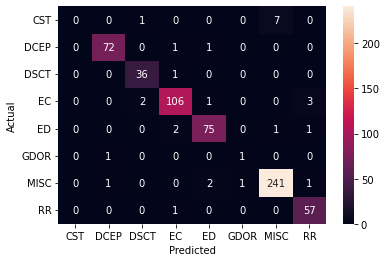

In [55]:
#From chatgpt
# Find unique labels and sort them
unique_labels = sorted(set(ypredfor).union(set(y_test)))

# Compute the confusion matrix with sorted labels
cm = metrics.confusion_matrix(y_test, ypredfor, labels=unique_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [9]:
sec15cam1to3types = pd.read_csv('Sector15_cam1-3_typenames_07-30-24.tsv', sep=';', comment='#',skip_blank_lines = False,header = 1)
sec15cam1to3types = sec15cam1to3types.drop([0,1])
sec15cam1to3types = sec15cam1to3types.reset_index()
sec15cam1to3types = sec15cam1to3types.drop('index',axis = 1)

l = []
for i in range(len(sec15cam1to3types['_1'])):
    if type(sec15cam1to3types['_1'][i]) != str:
        l.append(i)
        
sec15cam1to3types = sec15cam1to3types.drop(l)
sec15cam1to3types = sec15cam1to3types.reset_index()
sec15cam1to3types = sec15cam1to3types.drop('index',axis = 1)


sec15cam3data = pd.read_csv('Sector15_camera3_07-24-24.csv', sep=',', comment='#', dtype = str)
sec15cam1to2data = pd.read_csv('Sector15_cam1-2_07-30-24.csv', sep=',', comment='#', dtype = str)
sec15cam1to3data = pd.concat([sec15cam1to2data,sec15cam3data])
sec15cam1to3data = sec15cam1to3data.reset_index()
sec15cam1to3data = sec15cam1to3data.drop('index',axis = 1)

sec15cam1to3data = sec15cam1to3data.drop('Unnamed: 15',axis = 1)

sec15cam1to3 = pd.concat([sec15cam1to3types, sec15cam1to3data], axis=1)

m = []
for i in range(len(sec15cam1to3['Type'])):
    if type(sec15cam1to3['Type'][i]) != str:
        m.append(i)
        
sec15cam1to3 = sec15cam1to3.drop(m)
sec15cam1to3 = sec15cam1to3.dropna(axis=0)
sec15cam1to3 = sec15cam1to3.drop('_1',axis = 1)
sec15cam1to3 = sec15cam1to3.reset_index()
sec15cam1to3 = sec15cam1to3.drop('index',axis = 1)

sec15cam1to3

,Type,TIC_ID,Sector,Camera,CCD,vmag,kmag,w1mag,w4mag,teff,Jstet_2,RMSBin_60.0_3,LS_Period_1_4,LS_SNR_1_4,BLS_Period_1_5,BLS_SDE_1_5
0,EW,240538727,sector15,1,1,7.752999999999999,-1.405,2.4,-2.8539999999999996,3238.0,4.42715,0.00101,26.62063222,1172.3034400000001,23.958569,13.02933
1,LC,273546321,sector15,1,1,6.579,-0.038,-1.775,-0.17600000000000002,3592.0,5.14498,0.00141,26.000239,157.8418,26.000239,9.688360000000001
2,VAR,240455792,sector15,1,1,7.02,1.901,-0.045,1.8330000000000002,5439.0,5.0757,0.00161,25.896072,203.80868,25.896072,10.83206
3,LC,274278200,sector15,1,1,7.459,1.0270000000000001,-1.426,0.88,4510.0,29.195420000000002,0.00571,14.31726,786.45866,13.57017487,11.724839999999999
4,SRB,190660296,sector15,1,1,7.667000000000001,0.21,-1.649,-0.106,2583.0,15.163879999999999,0.0034,21.63214333,855.80221,15.76223299,10.38997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220566,BY,202426798,sector15,3,4,16.085,11.87,11.734000000000002,9.286,3432.0,0.09233,0.01127,21.66643333,194.54787,17.1239191,9.8017
220567,BY,198160160,sector15,3,4,14.675,12.084000000000001,12.026,9.587,4694.0,0.07683999999999999,0.02537,7.22214444,15.80561,23.0171178,5.81674
220568,BY,165715530,sector15,3,4,15.493,12.136,12.019,9.596,4068.0,0.40715,0.03408,1.91174412,138.94118999999998,13.63330848,7.9903
220569,EW,165723613,sector15,3,4,14.345,12.300999999999998,12.205,9.529,5193.0,4.3118300000000005,0.09497,0.13844366,10351.27961,0.27685716,9.83913


In [10]:
sec15cam1to3.rename(columns={'vmag': 'Vmag','kmag': 'Kmag','teff':'Teff','Jstet_2':'Jstet','RMSBin_60.0_3':'RMS_60m','LS_Period_1_4':'LS_Period','LS_SNR_1_4':'LS_SNR','BLS_Period_1_5':'BLS_Period','BLS_SDE_1_5':'BLS_SDE'}, inplace=True)
sec15cam1to3

,Type,TIC_ID,Sector,Camera,CCD,Vmag,Kmag,w1mag,w4mag,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE
0,EW,240538727,sector15,1,1,7.752999999999999,-1.405,2.4,-2.8539999999999996,3238.0,4.42715,0.00101,26.62063222,1172.3034400000001,23.958569,13.02933
1,LC,273546321,sector15,1,1,6.579,-0.038,-1.775,-0.17600000000000002,3592.0,5.14498,0.00141,26.000239,157.8418,26.000239,9.688360000000001
2,VAR,240455792,sector15,1,1,7.02,1.901,-0.045,1.8330000000000002,5439.0,5.0757,0.00161,25.896072,203.80868,25.896072,10.83206
3,LC,274278200,sector15,1,1,7.459,1.0270000000000001,-1.426,0.88,4510.0,29.195420000000002,0.00571,14.31726,786.45866,13.57017487,11.724839999999999
4,SRB,190660296,sector15,1,1,7.667000000000001,0.21,-1.649,-0.106,2583.0,15.163879999999999,0.0034,21.63214333,855.80221,15.76223299,10.38997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220566,BY,202426798,sector15,3,4,16.085,11.87,11.734000000000002,9.286,3432.0,0.09233,0.01127,21.66643333,194.54787,17.1239191,9.8017
220567,BY,198160160,sector15,3,4,14.675,12.084000000000001,12.026,9.587,4694.0,0.07683999999999999,0.02537,7.22214444,15.80561,23.0171178,5.81674
220568,BY,165715530,sector15,3,4,15.493,12.136,12.019,9.596,4068.0,0.40715,0.03408,1.91174412,138.94118999999998,13.63330848,7.9903
220569,EW,165723613,sector15,3,4,14.345,12.300999999999998,12.205,9.529,5193.0,4.3118300000000005,0.09497,0.13844366,10351.27961,0.27685716,9.83913


In [12]:
sec15cam1to3diff = magdiff(sec15cam1to3)
sec15cam1to3diff

,Type,TIC_ID,Sector,Camera,CCD,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE,VmKmag,w1mw4mag
0,EW,240538727,sector15,1,1,3238.0,4.42715,0.00101,26.62063222,1172.3034400000001,23.958569,13.02933,9.158,5.254
1,LC,273546321,sector15,1,1,3592.0,5.14498,0.00141,26.000239,157.8418,26.000239,9.688360000000001,6.617,-1.599
2,VAR,240455792,sector15,1,1,5439.0,5.0757,0.00161,25.896072,203.80868,25.896072,10.83206,5.119,-1.878
3,LC,274278200,sector15,1,1,4510.0,29.195420000000002,0.00571,14.31726,786.45866,13.57017487,11.724839999999999,6.432,-2.306
4,SRB,190660296,sector15,1,1,2583.0,15.163879999999999,0.0034,21.63214333,855.80221,15.76223299,10.38997,7.457,-1.543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220566,BY,202426798,sector15,3,4,3432.0,0.09233,0.01127,21.66643333,194.54787,17.1239191,9.8017,4.215,2.448
220567,BY,198160160,sector15,3,4,4694.0,0.07683999999999999,0.02537,7.22214444,15.80561,23.0171178,5.81674,2.591,2.439
220568,BY,165715530,sector15,3,4,4068.0,0.40715,0.03408,1.91174412,138.94118999999998,13.63330848,7.9903,3.357,2.423
220569,EW,165723613,sector15,3,4,5193.0,4.3118300000000005,0.09497,0.13844366,10351.27961,0.27685716,9.83913,2.044,2.676


In [13]:
MISC15,CST15,RR15,EC15,ED15,DSCT15,DCEP15,GDOR15 = septypes(sec15cam1to3diff)

In [14]:
print(len(MISC15))
print(len(CST15))
print(len(RR15))
print(len(EC15))
print(len(ED15))
print(len(DSCT15))
print(len(DCEP15))
print(len(GDOR15))

492
151
3938
77402
22916
4265
514
290


In [15]:
sec15types = pd.concat([MISC15,CST15,RR15,EC15,ED15,DSCT15,DCEP15,GDOR15])
sec15types_mix = sec15types.sample(frac = 1)
sec15types_mix = sec15types_mix.reset_index()
sec15types_mix = sec15types_mix.drop('TIC_ID',axis = 1)
sec15types_mix = sec15types_mix.drop('Sector',axis = 1)
sec15types_mix = sec15types_mix.drop('Camera',axis = 1)
sec15types_mix = sec15types_mix.drop('CCD',axis = 1)
sec15types_mix = sec15types_mix.drop('index',axis = 1)
sec15types_mix


,Type,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE,VmKmag,w1mw4mag
0,EC,4053.0,2.62196,0.02093,25.999679,465.72367,25.999679,10.09929,3.591,0.265
1,EC,3893.0,2.32497,0.0026899999999999997,12.38080333,3209.45025,12.00224259,11.37318,4.404,0.090
2,EC,6958.0,4.5048699999999995,0.00565,25.999687,636.97042,25.999687,10.657789999999999,1.992,3.280
3,EC,4341.0,10.24899,0.12949000000000002,25.999679,2032.5956800000001,25.999679,9.27063,3.633,0.159
4,EC,5104.0,0.02362,0.0038299999999999996,3.05885224,463.44097999999997,12.00236129,8.87692,3.568,1.399
...,...,...,...,...,...,...,...,...,...,...
109963,EC,4543.0,0.26264,0.00898,14.44427889,38.820440000000005,13.63330353,7.02912,2.931,0.968
109964,EC,2862.0,4.69707,0.00583,25.999679,1292.70774,13.63329721,10.246030000000001,6.457,0.294
109965,EC,7675.0,1.3670799999999999,0.02755,14.44427056,131.8971,13.63329941,13.02258,1.337,1.828
109966,ED,6640.0,0.5631,0.01195,2.12639603,285.93388999999996,4.19771233,6.96156,1.632,3.353


In [16]:
sec15typescut = pd.concat([MISC15.sample(150),CST15.sample(150),RR15.sample(150),EC15.sample(150),ED15.sample(150),DSCT15.sample(150),DCEP15.sample(150),GDOR15.sample(150)])
sec15typescut = sec15typescut.sample(frac = 1)
sec15typescut = sec15typescut.reset_index()
sec15typescut = sec15typescut.drop('TIC_ID',axis = 1)
sec15typescut = sec15typescut.drop('Sector',axis = 1)
sec15typescut = sec15typescut.drop('Camera',axis = 1)
sec15typescut = sec15typescut.drop('CCD',axis = 1)
sec15typescut = sec15typescut.drop('index',axis = 1)
sec15typescut

,Type,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE,VmKmag,w1mw4mag
0,GDOR,3801.0,0.18936,0.00336,14.44427278,117.92218999999999,13.63330051,10.52169,3.783,2.074
1,GDOR,4374.0,0.14062,0.00386,13.68404789,54.205290000000005,25.999691,9.034930000000001,4.058,0.751
2,ED,6567.0,0.41318999999999995,0.00586,8.96540931,136.04635,25.999687,8.34238,1.945,3.821
3,RR,5311.0,0.17375,0.00586,16.14599688,152.90517,14.57447075,11.21466,2.012,0.524
4,CST,4501.0,0.03483,0.04326,21.78051727,185.95063000000002,23.958569,12.54025,2.953,1.775
...,...,...,...,...,...,...,...,...,...,...
1195,EC,4358.0,0.9301,0.00624,25.999691,480.36539000000005,25.999691,8.31348,3.162,2.520
1196,GDOR,4270.0,0.8424299999999999,0.00434,12.9998455,388.92163999999997,25.999691,9.522160000000001,4.562,-0.274
1197,MISC,2798.0,0.78637,0.0018899999999999998,25.562188,169.19408,18.49379085,8.536710000000001,6.307,0.980
1198,DSCT,6985.0,-0.06775,0.0021899999999999997,7.22229,94.40133,26.000244,10.75671,1.729,2.321


In [144]:
cols = ['Teff','Jstet','RMS_60m','LS_Period','LS_SNR','BLS_Period','BLS_SDE','VmKmag','w1mw4mag']

bestcols(sec15typescut,cols,RandomForestClassifier(random_state=20,n_estimators=25),3,False)

0.28 ['VmKmag', 'LS_Period']
0.3333333333333333 ['RMS_60m', 'Jstet', 'LS_Period']
0.29333333333333333 All columns
Duration: 0:00:17.175632


In [143]:
bestcols(sec15types_mix,cols,RandomForestClassifier(random_state=20,n_estimators=25),3,False)

0.6964207769532955 ['BLS_Period', 'LS_Period']
0.6867088607594937 ['BLS_SDE', 'LS_Period', 'LS_SNR']
0.7125345555070566 All columns
Duration: 0:27:24.925672


In [59]:
mlcols = ['Teff','Jstet','RMS_60m','LS_Period','LS_SNR','BLS_Period','BLS_SDE','VmKmag','w1mw4mag']
sec15cam3pred = resulttypes(sec15cam3diff,forest,mlcols)
sec15cam3pred

,PredType,_1,Type,TIC_ID,Sector,Camera,CCD,Teff,Jstet,RMS_60m,LS_Period,LS_SNR,BLS_Period,BLS_SDE,VmKmag,w1mw4mag
0,MISC,263.066775 55.172897,I,229686919,sector15,3,1,4849.0,111.3888,0.013130000000000001,25.999712,1218.82611,25.999712,10.906419999999999,3.008,0.034
1,MISC,251.324154 56.781841,ROT+EA,199661915,sector15,3,1,6653.0,1.24987,0.0009599999999999999,19.99977846,50.46022,25.999712,6.495019999999999,3.721,0.056
2,MISC,252.069402 57.813708999999996,SRB,199666719,sector15,3,1,2334.0,105.85533999999998,0.012740000000000001,25.999712,5028.72087,25.999712,13.90986,8.138,-0.604
3,MISC,254.007112 65.134842,DSCT:,289622310,sector15,3,1,6459.0,17.992279999999997,0.00243,25.999712,443.10592,25.999712,12.93185,3.879,0.021
4,MISC,257.10211499999997 64.319099,SR,307985697,sector15,3,1,2241.0,38.25202,0.004370000000000001,25.999712,1165.9990400000002,25.999712,15.49099,8.534,-0.849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4836,MISC,226.700259 64.558601,BY,202426798,sector15,3,4,3432.0,0.09233,0.01127,21.66643333,194.54787,17.1239191,9.8017,4.215,2.448
4837,MISC,243.546658 60.113693000000005,BY,198160160,sector15,3,4,4694.0,0.07683999999999999,0.02537,7.22214444,15.80561,23.0171178,5.81674,2.591,2.439
4838,DCEP,230.658752 59.606911,BY,165715530,sector15,3,4,4068.0,0.40715,0.03408,1.91174412,138.94118999999998,13.63330848,7.9903,3.357,2.423
4839,EC,231.34763900000002 56.763664,EW,165723613,sector15,3,4,5193.0,4.3118300000000005,0.09497,0.13844366,10351.27961,0.27685716,9.83913,2.044,2.676


In [65]:
%%capture
resultplots(sec15cam3pred,'sec15cam3','Sector15_Camera3_Predicted')
;

In [20]:
%%capture
clean(MISC15.head(176),'MISC15_all','Sector15_images','sec15cam1to3',100,0)

In [17]:
%%capture
clean(CST15,'CST15_all','Sector15_images','sec15cam1to3',100,0)

In [21]:
%%capture
clean(DCEP15,'DCEP15_all','Sector15_images','sec15cam1to3',100,1.4)

ValueError: Illegal type <class 'numpy.bool_'> for table item access

In [18]:
%%capture
clean(GDOR15,'GDOR15_all','Sector15_images','sec15cam1to3',100,0)

In [115]:
%%capture
clean(RR15.head(100),'RR15to999','Sector15_images','sec15cam1to3',100,0)

KeyboardInterrupt: 

In [116]:
%%capture
clean(GDOR15,'GDOR15_all','Sector15_images','sec15cam1to3',100,0)